In [5]:
# load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from typing import Union
from tqdm import tqdm


In [6]:
# import data 
df = pd.read_csv("../Antidiabetic/AusAntidiabeticDrug.csv")
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


## Exploratory data analysis

In [7]:
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [15]:
df.tail()



,ds,y
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


In [16]:
df.shape

(204, 2)

- Visualizing the data to get a glimse of what it entails.

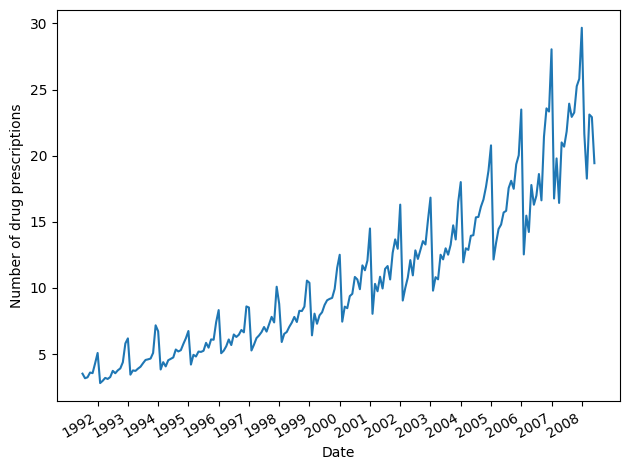

In [17]:

fig, ax = plt.subplots()
ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of drug prescriptions')
plt.xticks(np.arange(6,203,12),np.arange(1992,2009,1))
fig.autofmt_xdate()
plt.tight_layout()

### Step b:Exploration

- With time series decomposition below allows to visualize the trend, seasonality components and the residuals.


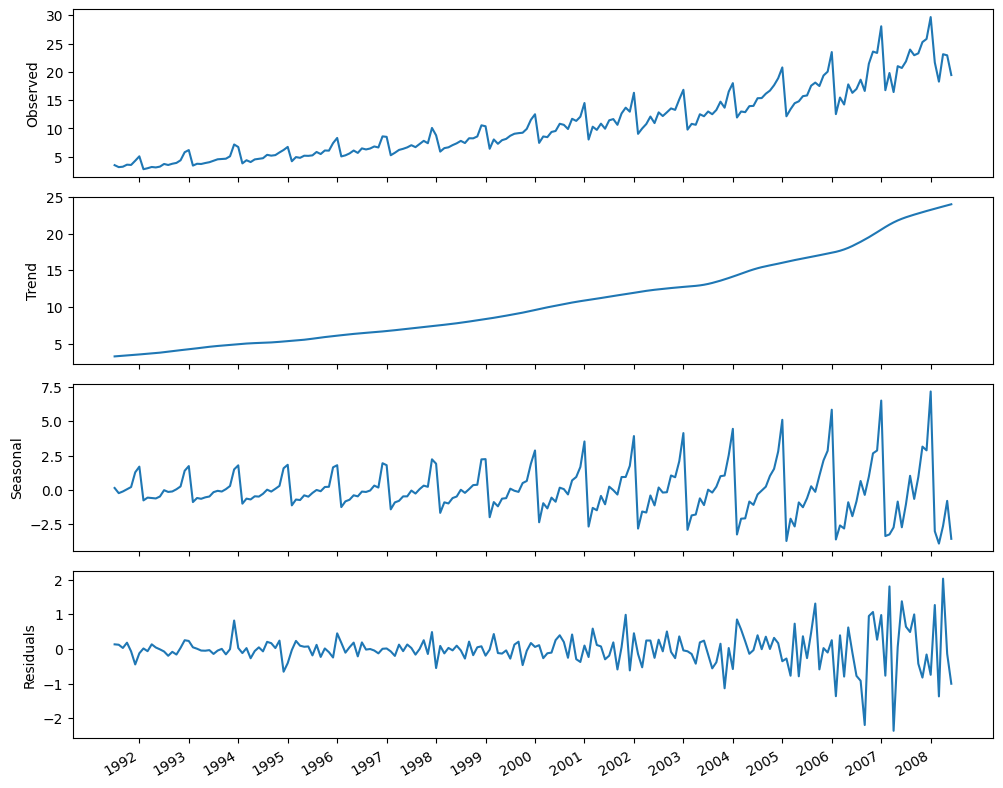

In [18]:

decomposition = STL(df.y,period=12).fit()
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(10,8))
ax1.plot(decomposition.observed)
ax1.set_ylabel("Observed")

ax2.plot(decomposition.trend)
ax2.set_ylabel("Trend")

ax3.plot(decomposition.seasonal)
ax3.set_ylabel("Seasonal")

ax4.plot(decomposition.resid)
ax4.set_ylabel("Residuals")

plt.xticks(np.arange(6,203,12),np.arange(1992,2009,1))
fig.autofmt_xdate()
plt.tight_layout()

In [8]:
# Step d .1 ,Check for stationarity 
ad_fuller_result = adfuller(df.y)
print(f"ADF statistics : {ad_fuller_result[0]}")
print(f"p-value: {ad_fuller_result[1]}")

ADF statistics : 3.14518568930673
p-value: 1.0


In [9]:
# difference 1st order 
y_diff = np.diff(df.y,n=1)
ad_fuller_result=adfuller(y_diff)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.4951721474497393
p-value: 0.11665341686468789


In [10]:
# differencing 1st order with n=12
y_diff_seasonal = np.diff(df.y,n=12)
ad_fuller_result=adfuller(y_diff_seasonal)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}') 

ADF Statistic: -18.779669954274326
p-value: 2.0243648094893943e-30


### model selection

- we chose the parameters that minimize the Akaike information criterion

In [11]:
train = df.y[:168]
test= df.y[168:]


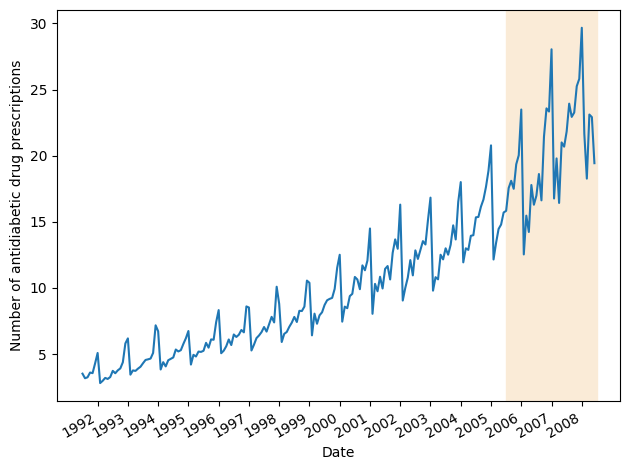

In [ ]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel("Date")
ax.set_ylabel("Number of antidiabetic drug prescriptions")

# highlight the last 3 year(36months ) test set for rolling predictions.
ax.axvspan(168,204, color="antiquewhite",alpha=1)
# rearranging the dates to look good 

plt.xticks(np.arange(6,204,12),np.arange(1992,2009,1))

# clarity of dates 
fig.autofmt_xdate()

plt.tight_layout()

#### Finding values of p,q and P,Q

In [37]:
def optimize_SARIMAX(endog: Union[pd.Series,list],
                     exog: Union[pd.Series,list],
                     order_list: list,
                     d: int,
                     D: int,
                     s: int)->pd.DataFrame:
    """
    endogenous features-> target features(demand)
    exogenous features -> others factors affecting the target feature
    order_list -> a list of tuples where each tuple contains(p,d,P,Q), representing different SARIMAX configurations to  test,
    d- degree of non- seasonality differencing 
    D - degree of seasonality differencing to  remove the seasonality pattern
    """
    results=[]

    for order in tqdm(order_list):# for progress bar 
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0],d,order[1]),
                seasonal_order=(order[2],D,order[3],s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order,model.aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)','AIC']
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df

In [38]:
# initializing some of the parameters
ps = range(0,5,1)
qs = range(0,5,1)
PS = range(0,5,1)
QS = range(0,5,1)

order_list = list(product(ps,qs,PS,QS))

d= 1
D = 1
s = 12

In [39]:
# running the above function to get the non-seasonal and seasonal degrees 
SARIMA_results_df = optimize_SARIMAX(train,None,order_list,d,D,s)
SARIMA_results_df 





/media/danlof/dan_files26/data_science_codes/Timeseries/Antidiabetic/timeseries/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'




/media/danlof/dan_files26/data_science_codes/Timeseries/Antidiabetic/timeseries/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

/media/danlof/dan_files26/data_science_codes/Timeseries/Antidiabetic/timeseries/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/media/danlof/dan_files26/data_science_codes/Timeseries/Antidiabetic/timeseries/lib/pyt

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(2, 4, 1, 3)",271.222312
2,"(3, 3, 1, 3)",271.375385
3,"(4, 1, 1, 3)",272.145292
4,"(0, 4, 1, 3)",272.152380
...,...,...
620,"(0, 0, 0, 4)",351.680917
621,"(0, 0, 2, 4)",353.222052
622,"(0, 0, 0, 1)",354.751719
623,"(0, 0, 1, 0)",357.173706


#### Residual analysis

In [12]:
SARIMA_model = SARIMAX(train,order=(3,1,1),seasonal_order=(1,1,3,12),simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
print(SARIMA_model_fit.summary())


                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  168
Model:             SARIMAX(3, 1, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -126.476
Date:                                    Fri, 04 Apr 2025   AIC                            270.951
Time:                                            00:43:59   BIC                            298.342
Sample:                                                 0   HQIC                           282.077
                                                    - 168                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0681      0.091      0.748      0

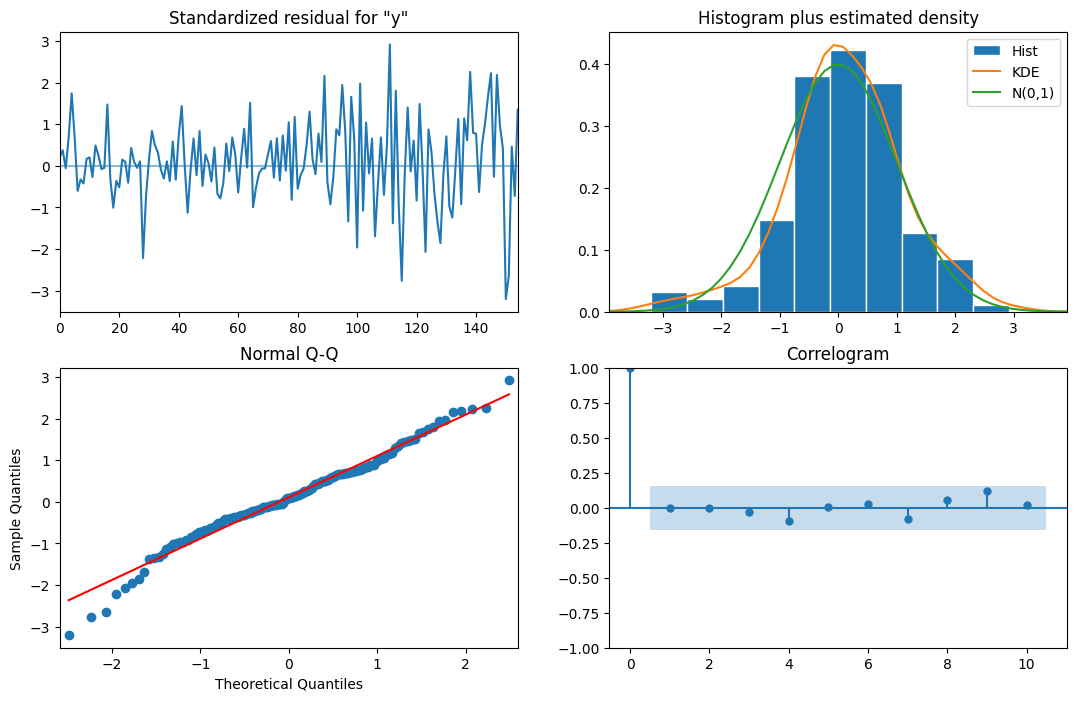

In [13]:
# plot diagnostics

SARIMA_model_fit.plot_diagnostics(figsize=(13,8));
plt.savefig('results/residual_diagnostics.png',dpi=300)

- Since it is important for residuals to be independent and uncorrelated , we  perform the Ljung -Box test.
- Hence our null hypothesis is that the residuals are uncorrelated. This means we need p-values larger than 0.05. 

In [14]:
residuals = SARIMA_model_fit.resid

lb_test = acorr_ljungbox(residuals, np.arange(1, 11, 1),return_df=True)

pvalues = lb_test["lb_pvalue"]
print(pvalues)


1     0.508697
2     0.730717
3     0.885832
4     0.688369
5     0.707616
6     0.758614
7     0.189585
8     0.225898
9     0.221658
10    0.286030
Name: lb_pvalue, dtype: float64


#### Forcasting

In [15]:
def rolling_forcast(df:pd.DataFrame,train_len:int, horizon: int,window: int,method:str)-> list:
    total_len =train_len + horizon
    end_idx = train_len

    if method == "last_season":
        pred_last_season = []
        for i in range(train_len,total_len,window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
        return pred_last_season
    elif method == 'SARIMA':
        pred_SARIMA=[]

        for i in range(train_len,total_len,window):
            model = SARIMAX(df['y'][:i],order=(3,1,1),seasonal_order=(1,1,3,12),simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0,i+window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
        return pred_SARIMA

In [16]:
pred_df = df[168:]
pred_df.head()

,ds,y
168,2005-07-01,15.829550
169,2005-08-01,17.554701
170,2005-09-01,18.100864
171,2005-10-01,17.496668
172,2005-11-01,19.347265


In [17]:
TRAIN_LEN = 168
HORIZON =36
WINDOW = 12

pred_df['last_season'] = rolling_forcast(df,TRAIN_LEN,HORIZON,WINDOW,'last_season')
pred_df.head()

/tmp/ipykernel_46582/289671789.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['last_season'] = rolling_forcast(df,TRAIN_LEN,HORIZON,WINDOW,'last_season')


,ds,y,last_season
168,2005-07-01,15.829550,15.339097
169,2005-08-01,17.554701,15.370764
170,2005-09-01,18.100864,16.142005
171,2005-10-01,17.496668,16.685754
172,2005-11-01,19.347265,17.636728


- Forcast from the SARIMA model


In [18]:
pred_df['SARIMA'] = rolling_forcast(df,TRAIN_LEN,HORIZON,WINDOW,'SARIMA')
pred_df.head()

/tmp/ipykernel_46582/1063857138.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['SARIMA'] = rolling_forcast(df,TRAIN_LEN,HORIZON,WINDOW,'SARIMA')


,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.745832
169,2005-08-01,17.554701,15.370764,16.619359
170,2005-09-01,18.100864,16.142005,17.255314
171,2005-10-01,17.496668,16.685754,18.107515
172,2005-11-01,19.347265,17.636728,18.722206


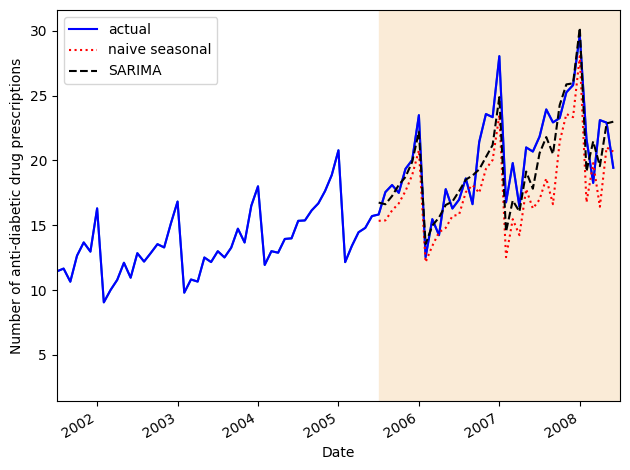

In [19]:
fig,ax = plt.subplots()

ax.plot(df.y)
ax.plot(df.y, 'b-',label="actual")
ax.plot(pred_df.last_season,'r:',label="naive seasonal")
ax.plot(pred_df.SARIMA,'k--',label="SARIMA")
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
# highlight the last 3 year(36months ) test set for rolling predictions.
ax.axvspan(168,204, color="antiquewhite",alpha=1)
# rearranging the dates to look good 
ax.legend(loc=2)

plt.xticks(np.arange(6,204,12),np.arange(1992,2009,1))
plt.xlim(120, 204)
# clarity of dates 
fig.autofmt_xdate()

plt.tight_layout()

plt.savefig('results/forcast.png')

#### Evaluation

In [20]:
def mape(y_true,y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [21]:
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.5633190621621935


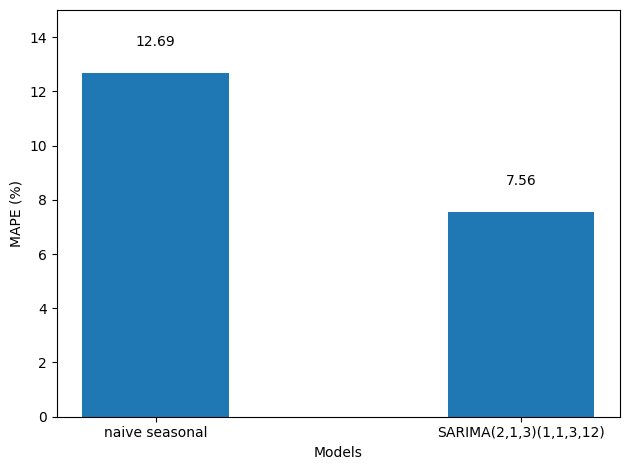

In [22]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(2,1,3)(1,1,3,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('results/mape.png', dpi=300)